# Exploring Covid-19 and non-Covid vaccine reports VAERS 2020

## ***Dataset***

Reports from VAERS, 2020. 
Download link: https://vaers.hhs.gov/data/datasets.html. 

#### Dataset description:

* Type of file: CSV
* 2020VAERSData.csv : contains information about vaccine data including symptom narratives (column SYMPTOM_TEXT). There exist other free-text fields on the reports. It has 35 columns and 5352 rows
* 2020VAERSVAX.csv : contains vaccine information. It has 8 columns and 5472 rows. Column VAX_NAME contains the vaccine name for the report and one can identify the COVID19 reports using this column. 

* Both files contain a unique ID VAERS_ID for linking the tables. 

* The data is from the US in 2020, and includes reports for Covid-19 vaccines and other vaccines. 

#### Set up:

Create a new virtual environment and install all the necessary Python packages: <br>

`conda create --name env_name python=3.8 pip numpy pandas matplotlib seaborn altair jupyterlab` <br>
`conda activate env_name` <br>
`pip install wordcloud`

For ScispaCy (Mac): <br>
`CFLAGS="-mavx -DWARN(a)=(a)" pip install nmslib` 
`pip install scispacy`


For ScispaCy (Windows): 
`pip install scispacy` 

___

### Data Cleaning

Select and mutate the required columns, deal with null values, change data types and remove outliers.

In [ ]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import altair as alt
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#### Import data and filter useful features

In [2]:
data_VAERS = pd.read_csv('data/2020VAERSData.csv', encoding = "ISO-8859-1")
data_VAERS = data_VAERS.iloc[:,[0,2,3,6,8,9,20,24,25,26,34]]
data_VAERS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49634 entries, 0 to 49633
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   VAERS_ID      49634 non-null  int64  
 1   STATE         42718 non-null  object 
 2   AGE_YRS       38023 non-null  float64
 3   SEX           49634 non-null  object 
 4   SYMPTOM_TEXT  49627 non-null  object 
 5   DIED          171 non-null    object 
 6   NUMDAYS       39410 non-null  float64
 7   OTHER_MEDS    25819 non-null  object 
 8   CUR_ILL       21680 non-null  object 
 9   HISTORY       24617 non-null  object 
 10  ALLERGIES     23579 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 4.2+ MB


/var/folders/zw/0jzfyrh57xv890gm4fxvzz300000gn/T/ipykernel_64694/2499133217.py:1: DtypeWarning: Columns (7,9,10,12,15,16,23,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data_VAERS = pd.read_csv('data/2020VAERSData.csv', encoding = "ISO-8859-1")


#### Description (VAERS Data):

Reference: https://vaers.hhs.gov/docs/VAERSDataUseGuide_en_September2021.pdf

* VAERS_ID: VAERS identification number
* STATE: State (e.g. WI, TX, FL, GA, etc.)
* AGE_YRS: Age in years
* SEX: Sex (M/F/U)
* SYMPTOM_TEXT: Reported symptom text
* DIED: Y or NaN
* NUMDAYS: Number of days (onset date - vaccination date)
* OTHER_MEDS: Other medications
* CUR_ILL: Illnesses at time of vaccination
* HISTORY: Chronic or long-standing health conditions
* ALLERGIES: Allergis to medications, food, or other products

In [3]:
data_vax = pd.read_csv('data/2020VAERSVAX.csv')
data_vax = data_vax.iloc[:,[0,1,7]]
data_vax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59641 entries, 0 to 59640
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   VAERS_ID  59641 non-null  int64 
 1   VAX_TYPE  59641 non-null  object
 2   VAX_NAME  59641 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


#### Description (VAERS VAX):

Reference: https://vaers.hhs.gov/docs/VAERSDataUseGuide_en_September2021.pdf

* VAERS_ID: VAERS identification number
* VAX_TYPE: Administered vaccine type (e.g. COVID19, VARZOS, MMR, RV5, etc.)
* VAX_NAME: Vaccination name (e.g. COVID19 (COVID19 (PFIZER-BIONTECH)))

#### *Merge*
Merge 2020VAERSDATA.csv and 2020VAERSVAX.csv into one dataset called `df_VAERS`.

In [4]:
df_VAERS = data_VAERS.merge(data_vax, on='VAERS_ID', how='inner')

### Summary statistics

In [5]:
df_VAERS.describe(include='all')

,VAERS_ID,STATE,AGE_YRS,SEX,SYMPTOM_TEXT,DIED,NUMDAYS,OTHER_MEDS,CUR_ILL,HISTORY,ALLERGIES,VAX_TYPE,VAX_NAME
count,59641.00000,51889,46426.00000,59641,59622,263,47893.00000,31716,27186,30091,29114,59641,59641
unique,NaN,66,NaN,3,48371,1,NaN,16046,4743,10438,8498,62,124
top,NaN,CA,NaN,F,UNMONITORED TEMP FOR 63H,Y,NaN,None,None,None,None,VARZOS,ZOSTER (SHINGRIX)
freq,NaN,4648,NaN,34634,191,263,NaN,3912,8286,5311,4705,12752,11451
mean,886033.15015,NaN,40.79508,NaN,NaN,NaN,26.61832,NaN,NaN,NaN,NaN,NaN,NaN
std,17261.81899,NaN,26.06272,NaN,NaN,NaN,600.37158,NaN,NaN,NaN,NaN,NaN,NaN
min,855017.00000,NaN,0.00000,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
25%,871707.00000,NaN,16.00000,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
50%,886091.00000,NaN,46.00000,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
75%,900405.00000,NaN,64.00000,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN


#### Deal with null values

We fill null values in `age`, `numdays` and `Died`.

In [6]:
# fill null values of age with the mean age
df_VAERS.AGE_YRS = df_VAERS.AGE_YRS.fillna(df_VAERS.AGE_YRS.mean())

# fill null values of NUMDAYS with the median NUMDAYS
df_VAERS.NUMDAYS = df_VAERS.NUMDAYS.fillna(df_VAERS.NUMDAYS.median())

# fill null values of DIED
# DIED = 1: the patient died; DIED = 0: unknown
df_VAERS.DIED = df_VAERS.DIED.fillna(0)
df_VAERS.loc[df_VAERS['DIED'] == 'Y','DIED'] = 1

####  Change data types

In [7]:
# change age and 'NUMDAYS' to integer
df_VAERS.AGE_YRS = df_VAERS.AGE_YRS.astype('int64')
df_VAERS.NUMDAYS = df_VAERS.NUMDAYS.astype('int64')

#### Create a new column, converting continuous age to age groups

In [8]:
# Binning age groups.
bins= [0,15,30,40,50,60,70,80,110]
labels = ['0-15','15-30','30-40','40-50','50-60','60-70','70-80','80+']

# create a new column of age group
df_VAERS['AGE_GROUP'] = df_VAERS['AGE_YRS']
df_VAERS['AGE_GROUP'] = pd.cut(df_VAERS.AGE_YRS, bins=bins, labels=labels, right=False)

#### More missing values!

In [9]:
df_VAERS['STATE'].fillna('Unspecified', inplace = True)
df_VAERS['SYMPTOM_TEXT'].fillna('Unspecified', inplace = True)
df_VAERS['OTHER_MEDS'].fillna('Unspecified', inplace = True)
df_VAERS['CUR_ILL'].fillna('Unspecified', inplace = True)
df_VAERS['HISTORY'].fillna('Unspecified', inplace = True)
df_VAERS['ALLERGIES'].fillna('Unspecified', inplace = True)
df_VAERS.shape

(59641, 14)

#### Convert SYMPTOM_TEXT into lower-case to make it consistent.

In [10]:
df_VAERS['SYMPTOM_TEXT'] = df_VAERS['SYMPTOM_TEXT'].str.lower()
df_VAERS.head()

,VAERS_ID,STATE,AGE_YRS,SEX,SYMPTOM_TEXT,DIED,NUMDAYS,OTHER_MEDS,CUR_ILL,HISTORY,ALLERGIES,VAX_TYPE,VAX_NAME,AGE_GROUP
0,855017,HI,55,F,symptoms occurred almost immediately- aching j...,0,0,Loristan,None,Migraines,Morphine,VARZOS,ZOSTER (SHINGRIX),50-60
1,855018,WI,68,F,"extreme pain, muscle weakness in right arm so ...",0,0,"levothyroxine, multi vitamin, calcium.",None,"Hypothyroidism, Meniere's Disease.","Penicillin, sulfa drugs, erythromycin, tetracy...",UNK,VACCINE NOT SPECIFIED (OTHER),60-70
2,855019,Unspecified,50,F,soreness in the area. itching and rash,0,6,Unspecified,Unspecified,Unspecified,Unspecified,VARZOS,ZOSTER (SHINGRIX),50-60
3,855020,TX,67,F,"sore arm, fever 101 , chills, and aching musc...",0,31,"multi vitamin, calcium, premarin cream",none,none,"morphine,",VARZOS,ZOSTER (SHINGRIX),60-70
4,855021,Unspecified,73,F,patient presented to clinic today 1/1/2020. sh...,0,0,Unspecified,Unspecified,Unspecified,Unspecified,VARZOS,ZOSTER (SHINGRIX),70-80


### Named Entity Recognition (NER) on SYMPTOM_TEXT using ScispaCy

Model used: `en_ner_bc5cdr_md`. A spaCy NER model trained on the BC5CDR corpus. <br>
Link: https://allenai.github.io/scispacy/ <br>
It includes only 2 entity types: DISEASE and CHEMICAL <br>

Set up (for Mac): <br>
`CFLAGS="-mavx -DWARN(a)=(a)" pip install nmslib` <br>
`pip install scispacy` <br> <br>

Set up (for Windows): <br>
`pip install scispacy` <br>

In [11]:
# uncomment to install en_ner_bc5cdr_md model

#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz --user

***The ScispaCy NLP pipeline generates a Document or Doc object containing the structured data extracted from the text.***

The pipeline performs tasks such as: Tokenization ( breaking a text into meaningful tokens); Tagging (e.g., nouns, verbs); Lemmatization (e.g., pain, paining, all stem from the word "pain"); NER.

In [12]:
nlp = spacy.load("en_ner_bc5cdr_md")
doc = nlp(df_VAERS['SYMPTOM_TEXT'][0])

In [13]:
#print("Entity", "\t", "Label")
print("Symptoms:")
for ent in doc.ents:
    print(f"{ent.text}")

Symptoms:
aching joints
fever
chills


##### ***Let's display first 5 symptom text narratives and the corresponding entities found using ScispaCy NER.***

In [14]:
for i in range(5):
    mytext = df_VAERS['SYMPTOM_TEXT'][i]
    doc = nlp(mytext)
    print('\n', mytext)
    print("Symptoms:")
    for ent in doc.ents:
        print(f"{ent.text}")


 symptoms occurred almost immediately- aching joints, fever, chills, soreness at injection site - last for 3 days
Symptoms:
aching joints
fever
chills

 extreme pain, muscle weakness in right arm so severe that i could not move my arm, extreme vertigo, tremors throughout body and in hands, fingertip numbness both hands, fever, chills, fatigue, high blood pressure. the walk in clinic doctor thought i was having a stroke (i wasn't).
Symptoms:
pain
muscle weakness
vertigo
tremors
fingertip numbness
fever
chills
fatigue
stroke

 soreness in the area.  itching and rash
Symptoms:
itching
rash

 sore arm,  fever 101 , chills, and aching muscles, flu like symptons
Symptoms:
sore
fever
chills

 patient presented to clinic today 1/1/2020. she reports she received the 2nd dose of her shingrix vaccine yesterday 12/31/2019 at 12:30 noon at another location. she reports starting yesterday at about 5:30 pm she experienced chills, nausea (no vomiting), intermittent dizziness and racing heart rate whe

##### Clearly the NER is not perfect, but it manages to extract some important symptoms

In [15]:
df_VAERS = df_VAERS.assign(SYMPTOMS_LIST=None)
#df_VAERS.head()

***SYMPTOM_TEXT --> SYMPTOMS_LIST*** <br>

In [17]:
# import pickle

# with open('2020VAERSProcessed.pickle', 'wb') as handle:
#     pickle.dump(df_VAERS, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
import pickle

with open('2020VAERSProcessed.pickle', 'rb') as handle:
    df_Processed = pickle.load(handle)

In [19]:
df_Processed.head()

,VAERS_ID,STATE,AGE_YRS,SEX,SYMPTOM_TEXT,DIED,NUMDAYS,OTHER_MEDS,CUR_ILL,HISTORY,ALLERGIES,VAX_TYPE,VAX_NAME,AGE_GROUP,SYMPTOMS_LIST
0,855017,HI,55,F,symptoms occurred almost immediately- aching j...,0,0,Loristan,None,Migraines,Morphine,VARZOS,ZOSTER (SHINGRIX),50-60,"[aching joints, fever, chills]"
1,855018,WI,68,F,"extreme pain, muscle weakness in right arm so ...",0,0,"levothyroxine, multi vitamin, calcium.",None,"Hypothyroidism, Meniere's Disease.","Penicillin, sulfa drugs, erythromycin, tetracy...",UNK,VACCINE NOT SPECIFIED (OTHER),60-70,"[pain, muscle weakness, vertigo, tremors, fing..."
2,855019,Unspecified,50,F,soreness in the area. itching and rash,0,6,Unspecified,Unspecified,Unspecified,Unspecified,VARZOS,ZOSTER (SHINGRIX),50-60,"[itching, rash]"
3,855020,TX,67,F,"sore arm, fever 101 , chills, and aching musc...",0,31,"multi vitamin, calcium, premarin cream",none,none,"morphine,",VARZOS,ZOSTER (SHINGRIX),60-70,"[sore, fever, chills]"
4,855021,Unspecified,73,F,patient presented to clinic today 1/1/2020. sh...,0,0,Unspecified,Unspecified,Unspecified,Unspecified,VARZOS,ZOSTER (SHINGRIX),70-80,"[12/31/2019, chills, nausea, intermittent dizz..."


In [20]:
df_Processed['SYMPTOMS_LIST'].fillna("", inplace=True)

## Data exploration and analysis:
#### ***Are COVID-19 vaccine narratives different from narratives for other vaccines?*** <br> <br>

Let's start by preparing data into partitions: `df_covid` and `df_other_vacs`

In [21]:
df_other_vacs, df_covid = [x for _, x in df_Processed.groupby(df_Processed['VAX_TYPE'] == 'COVID19')]

# convert symptoms list into string
df_covid['SYMPTOMS_LIST'] = df_covid['SYMPTOMS_LIST'].apply(lambda x: ' '.join(map(str, x)))
df_other_vacs['SYMPTOMS_LIST'] = df_other_vacs['SYMPTOMS_LIST'].apply(lambda x: ' '.join(map(str, x)))

In [22]:
df_covid.reset_index(inplace=True)
df_other_vacs.reset_index(inplace=True)
df_covid.head()

,index,VAERS_ID,STATE,AGE_YRS,SEX,SYMPTOM_TEXT,DIED,NUMDAYS,OTHER_MEDS,CUR_ILL,HISTORY,ALLERGIES,VAX_TYPE,VAX_NAME,AGE_GROUP,SYMPTOMS_LIST
0,46486,902418,NJ,56,F,patient experienced mild numbness traveling fr...,0,0,latex,none,none,none,COVID19,COVID19 (COVID19 (PFIZER-BIONTECH)),50-60,numbness
1,46505,902440,AZ,35,F,c/o headache,0,0,Unspecified,Unspecified,Unspecified,Unspecified,COVID19,COVID19 (COVID19 (PFIZER-BIONTECH)),30-40,headache
2,46512,902446,WV,55,F,"felt warm, hot and face and ears were red and ...",0,0,"Novasc, Hydrochlorothiazide, synthroid, lisino...",none,"Hypertension, sleep apnea, hypothyroidism","Contrast Dye IV contrast, shellfish, strawberry",COVID19,COVID19 (COVID19 (PFIZER-BIONTECH)),50-60,
3,46531,902464,LA,42,M,within 15 minutes progressive light-headedness...,0,0,none,none,none,none,COVID19,COVID19 (COVID19 (PFIZER-BIONTECH)),40-50,light-headedness near-syncope diaphoresis
4,46532,902465,AR,60,F,pt felt wave come over body @ 1218 starting in...,0,0,"Lisinopril, HCTZ, lipitor, amyitrypline, lexap...","Bronchitis, finished prednisone on 12-13-20","hypertension, fibromyalgia",Biaxin,COVID19,COVID19 (COVID19 (PFIZER-BIONTECH)),60-70,taste in mouth itching


How many unique vaccine types are in the dataset?

In [23]:
print(df_Processed['VAX_TYPE'].nunique())

62


In [24]:
#!pip install wordcloud

In [25]:
from wordcloud import WordCloud

wctext_covid = df_covid['SYMPTOMS_LIST'].values
wctext_other = df_other_vacs['SYMPTOMS_LIST'].values

In [26]:
wctext_covid = ' '.join(str(x) for x in wctext_covid)
wctext_other = ' '.join(str(x) for x in wctext_other)

### Case 1: Comparing COVID19 vaccine narratives with 61 other non-COVID19 vaccines.

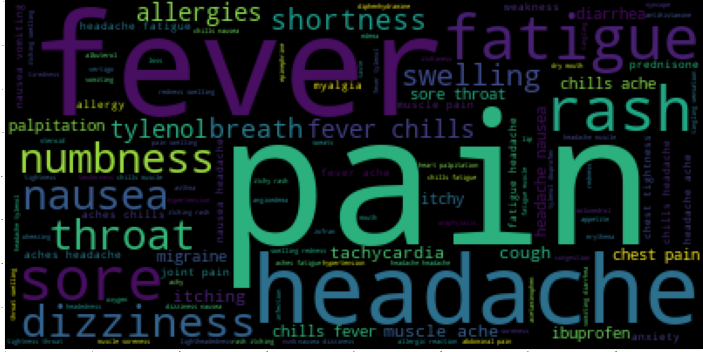

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')

figure(figsize=(90, 72), dpi=10)

wordcloud_covid = WordCloud().generate(wctext_covid)
plt.imshow(wordcloud_covid)

plt.show()

<b> Word cloud: Covid19 Vaccine symptoms

Pain, headache, fever, chills and fatigue are some of the most frequently occurring symptoms after COVID19 vaccine.

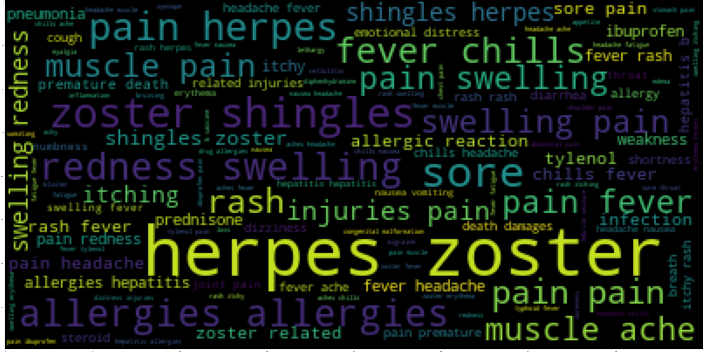

In [28]:
figure(figsize=(90, 72), dpi=10)

wordcloud_other = WordCloud().generate(wctext_other)
plt.imshow(wordcloud_other)

plt.show()

<b> Word cloud: Non-Covid19 Vaccine symptoms

Word cloud for non-COVID19 vaccine symtoms is more spread out, as it represents the most frequent symptoms for 61 different vaccines.

In [29]:
from collections import Counter

# Split symptoms string into words
split_it = wctext_covid.lower().split()

# Pass the split_it list to instance of Counter class
Counters_found = Counter(split_it)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counters_found.most_common(10)
print(most_occur)

[('pain', 2554), ('headache', 2353), ('fever', 1684), ('chills', 1626), ('fatigue', 1306), ('aches', 1298), ('nausea', 1256), ('throat', 1066), ('rash', 878), ('swelling', 868)]


In [30]:
split_it_other = wctext_other.lower().split()

# Pass the split_it list to instance of Counter class
Counters_found_other = Counter(split_it_other)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur_other = Counters_found_other.most_common(10)
print(most_occur_other)

[('pain', 13340), ('fever', 7807), ('zoster', 6816), ('herpes', 5482), ('rash', 5455), ('swelling', 5302), ('headache', 4093), ('redness', 3362), ('allergies', 3321), ('chills', 3230)]


In [31]:
x_val = [x[0] for x in most_occur]
y_val = [x[1] for x in most_occur]

x_val_oth = [x[0] for x in most_occur_other]
y_val_oth = [x[1] for x in most_occur_other]

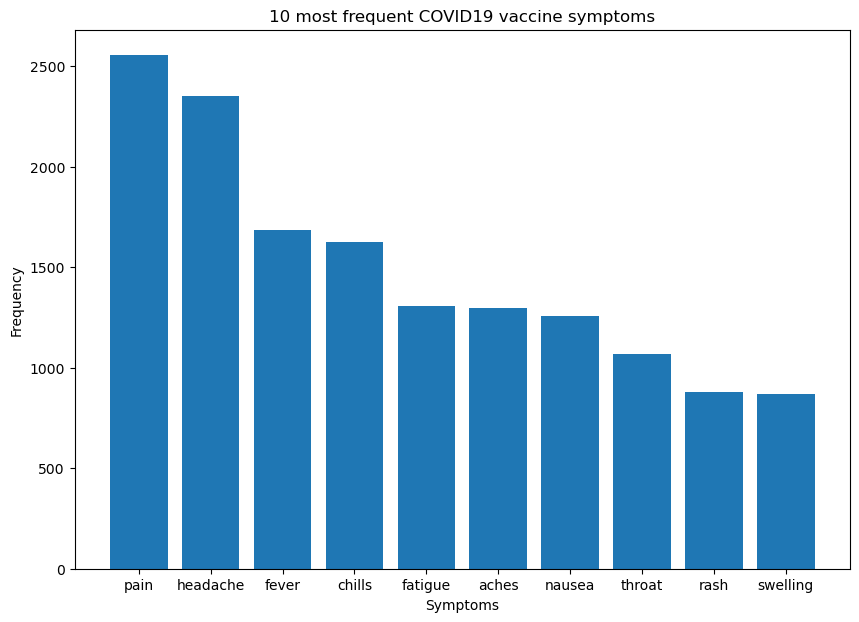

In [32]:
figure(figsize=(10, 7))

bar1=plt.bar(x_val, y_val)
plt.title("10 most frequent COVID19 vaccine symptoms")
plt.ylabel("Frequency")
plt.xlabel("Symptoms")
plt.show()

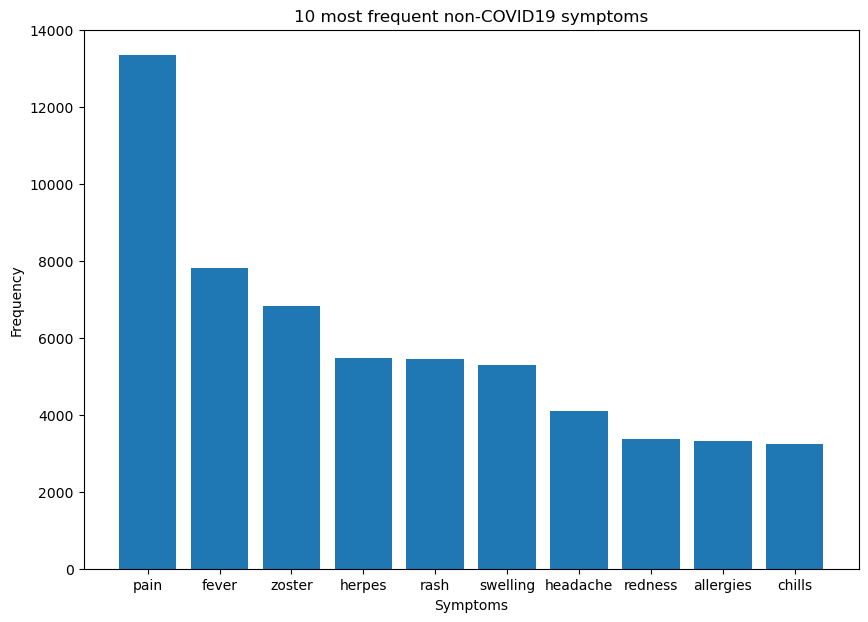

In [33]:
figure(figsize=(10, 7))

bar2=plt.bar(x_val_oth, y_val_oth)
plt.title("10 most frequent non-COVID19 symptoms")
plt.ylabel("Frequency")
plt.xlabel("Symptoms")
plt.show()

In [34]:
# extract common symptoms across the two cases
# we normalize by the total number of records in each case
# format: symptom, #non-covid occurences, #covid occurences
pairs = [(val1, (val2/len(df_other_vacs)) * 100, (val4/len(df_covid)) * 100) for val1,val2 in most_occur_other for val3,val4 in most_occur if val1 == val3]
pairs

[('pain', 27.0906949352179, 24.56005385133186),
 ('fever', 15.854351975955487, 16.193864794691798),
 ('rash', 11.077941594573739, 8.443119530724108),
 ('swelling', 10.767231225376712, 8.34695643811905),
 ('headache', 8.312010072702165, 22.627175689970187),
 ('chills', 6.55944112749279, 15.63611885758246)]

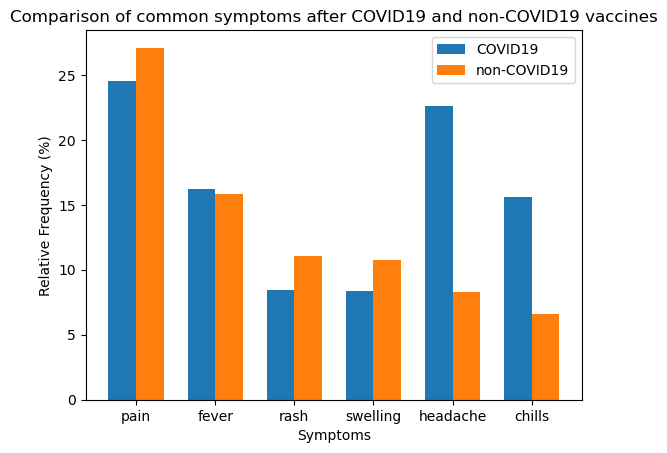

In [35]:
x_val = [x[0] for x in pairs]
y_noncovid = [x[1] for x in pairs]
y_covid = [x[2] for x in pairs]

x = np.arange(len(x_val))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y_covid, width, label='Covid')
rects2 = ax.bar(x + width/2, y_noncovid, width, label='Non-Covid')

plt.title("Comparison of common symptoms after COVID19 and non-COVID19 vaccines")
plt.ylabel("Relative Frequency (%)")
plt.xlabel("Symptoms")

plt.legend( (rects1, rects2), ('COVID19', 'non-COVID19') )
ax.set_xticks(x, x_val)
plt.show()

Observations: 
* Pain (e.g. injection site) dominate in both COVID19 and non-COVID19 vaccine symptoms.
* Headache and chills are more common symptoms after COVID19 vaccine as compared to other vaccines studied. 
* Majority of patients reported pain (injection site) and fever after both COVID19 and non-COVID19 vaccines.
* Comparing COVID19 and non-COVID19 narratives, headache and chills are found to be 2 main symptoms that occur more frequently after COVID19 vaccine as compared to other vaccines. 
* Since we are comparing COVID19 vaccine symptoms against 61 other vaccines, as a next step, we can explore the symptoms specificially for Flu vaccines and compare with COVID19 symptoms.

### Case 2: Comparing COVID19 and FLU vaccine narratives.

In [36]:
df_flu = df_Processed.loc[df_Processed['VAX_TYPE'].str.contains("FLU"), :]
df_flu['SYMPTOMS_LIST'] = df_flu['SYMPTOMS_LIST'].apply(lambda x: ' '.join(map(str, x)))
df_flu.reset_index(inplace=True)
df_flu.head()

,index,VAERS_ID,STATE,AGE_YRS,SEX,SYMPTOM_TEXT,DIED,NUMDAYS,OTHER_MEDS,CUR_ILL,HISTORY,ALLERGIES,VAX_TYPE,VAX_NAME,AGE_GROUP,SYMPTOMS_LIST
0,10,855027,IN,76,F,patient stated that 3-4 days after getting the...,0,4,None that the pharmacy was aware of.,None listed,None listed,None that the pharmacy is aware of.,FLU3,INFLUENZA (SEASONAL) (FLUZONE HIGH-DOSE),70-80,pain bacitracin
1,11,855028,OR,44,F,patient described having pain down her legs an...,0,0,Unspecified,Unspecified,Unspecified,Unspecified,FLUR4,INFLUENZA (SEASONAL) (FLUBLOK QUADRIVALENT),40-50,pain
2,14,855032,CA,36,F,patient is complaint of left shoulder pain sin...,0,0,I don't know,I don't know,I don't know if patient has any long standing ...,No known allergy,FLU4,INFLUENZA (SEASONAL) (FLUZONE QUADRIVALENT),30-40,left shoulder pain pain
3,21,855036,Unspecified,66,M,rash on right arm and nausea,0,3,Unspecified,Unspecified,Unspecified,Unspecified,FLU3,INFLUENZA (SEASONAL) (FLUZONE HIGH-DOSE),60-70,rash
4,27,855039,UT,31,F,the next morning after receiving my flu vaccin...,0,1,NuvaRing Vaginal Ring Birth Control,Got a 102 Fever and was sick in the beginning ...,Unspecified,Possible Penicillin allergy,FLUC4,INFLUENZA (SEASONAL) (FLUCELVAX QUADRIVALENT),30-40,sore canker sore


In [37]:
wctext_flu = df_flu['SYMPTOMS_LIST'].values
wctext_flu = ' '.join(str(x) for x in wctext_flu)

In [38]:
wordcloud_covid = WordCloud().generate(wctext_covid)
wordcloud_flu = WordCloud().generate(wctext_flu)

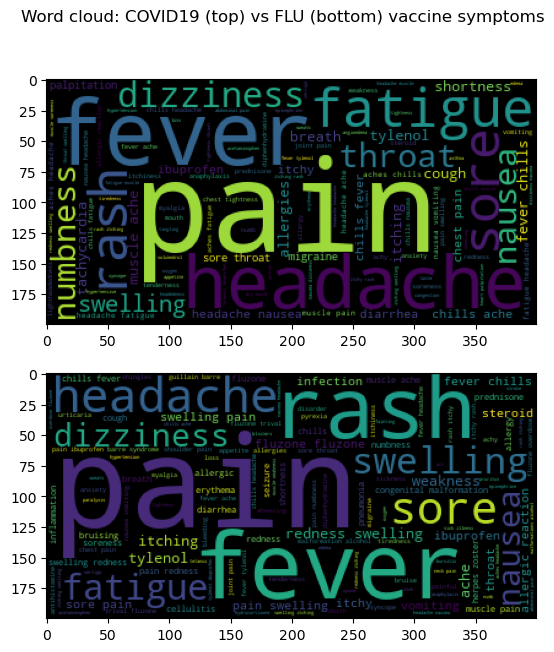

In [39]:
f, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))
f.suptitle('Word cloud: COVID19 (top) vs FLU (bottom) vaccine symptoms')
ax1.imshow(wordcloud_covid)
ax2.imshow(wordcloud_flu)

In [40]:
split_it_flu = wctext_flu.lower().split()

# Pass the split_it list to instance of Counter class
Counters_found_flu = Counter(split_it_flu)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur_flu = Counters_found_flu.most_common(10)
print(most_occur_flu)

[('pain', 3306), ('swelling', 1368), ('fever', 1328), ('rash', 892), ('fluzone', 798), ('redness', 770), ('sore', 735), ('headache', 723), ('chills', 677), ('nausea', 551)]


In [41]:
x_val_flu = [x[0] for x in most_occur_flu]
y_val_flu = [x[1] for x in most_occur_flu]

In [42]:
# extract common symptoms across the two cases
# we normalize by the total number of records in each case
# format: symptom, #flu occurences, #covid occurences
pairs2 = [(val1, (val2/len(df_flu)) * 100, (val4/len(df_covid)) * 100) for val1,val2 in most_occur_flu for val3,val4 in most_occur if val1 == val3]
pairs2

[('pain', 26.594803314294907, 24.56005385133186),
 ('swelling', 11.004746199018582, 8.34695643811905),
 ('fever', 10.682969994368916, 16.193864794691798),
 ('rash', 7.175609363687556, 8.443119530724108),
 ('headache', 5.816104899042716, 22.627175689970187),
 ('chills', 5.446062263695599, 15.63611885758246),
 ('nausea', 4.432467219049151, 12.078084431195308)]

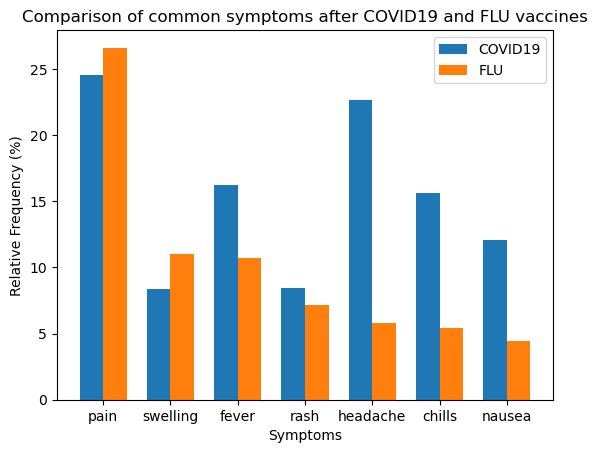

In [43]:
x_val2 = [x[0] for x in pairs2]
y_flu = [x[1] for x in pairs2]
y_covid2 = [x[2] for x in pairs2]

x = np.arange(len(x_val2))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y_covid2, width, label='Covid19')
rects2 = ax.bar(x + width/2, y_flu, width, label='Flu')

plt.title("Comparison of common symptoms after COVID19 and FLU vaccines")
plt.ylabel("Relative Frequency (%)")
plt.xlabel("Symptoms")

plt.legend( (rects1, rects2), ('COVID19', 'FLU') )
ax.set_xticks(x, x_val2)
plt.show()

Observations: 
* Pain (e.g. injection site) dominate in both COVID19 and FLU vaccine symptoms.
* Headache, chills and nausea are more common symptoms after COVID19 vaccine as compared to the Flu vaccines studied. 
* Fever is relatively more common after COVID19 vaccine as compared to Flu vaccines.

#### Exploring the COVID19 vaccines further, let's visualise the percentages of COVID19 vaccine reports based on the vaccine names/manufacturers

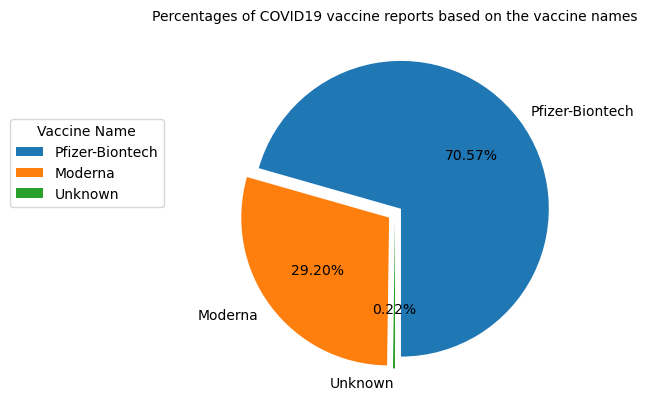

In [44]:
# Group by vaccine name
df_vax_gp=df_covid.groupby(['VAX_NAME'])[['VAERS_ID']].count().sort_values('VAERS_ID',ascending = False)

# Create pie chart
labels = 'Pfizer-Biontech', 'Moderna', 'Unknown'
sizes = df_vax_gp
explode = (0.05, 0.05, 0.05) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes["VAERS_ID"], explode=explode, labels=labels, autopct='%1.2f%%', textprops={'fontsize': 10}, shadow=False, startangle=270)
plt.title('Percentages of COVID19 vaccine reports based on the vaccine names', y=1, fontsize=10)
plt.legend(labels, bbox_to_anchor=(-0.1,0.6), loc="center left", 
                          bbox_transform=plt.gcf().transFigure, fontsize=10, title = 'Vaccine Name')
plt.show()

#### Which age groups and gender are more susceptible to have side effects from COVID19 vaccine?

Analyzing the number of COVID19 narratives for different age groups and sex.

In [45]:
# Group the age groups and sex
df_age_gender = df_covid.groupby(['AGE_GROUP', 'SEX'])[['VAERS_ID']].count()
df_age_gender.reset_index(level = ['AGE_GROUP'], inplace = True)
df_age_gender.reset_index(level = ['SEX'], inplace = True)

# Visualization in altair
alt.Chart(df_age_gender, title = "Age group and gender analysis").mark_bar().encode(   
         alt.Y('VAERS_ID', title = 'No. of COVID19 narratives'),
         alt.X('AGE_GROUP', title = 'AGE GROUP'),
         color = 'SEX'
).properties(width = 500)

alt.Chart(...)

Women are more susceptible to post-vaccination symptoms.

## *References*

1. Dataset, VAERS: https://vaers.hhs.gov/data/datasets.html
2. ScispaCy: https://allenai.github.io/scispacy/
3. SequenceMatcher: https://docs.python.org/3/library/difflib.html

Thank you! 